# Makemore: Implement the paper MLP

Following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and [karpathy Andrej's](https://github.com/karpathy/makemore) repo, we try to implement the model step by step with the following

1. `makemore-practice-part1-paper-mlp`: 
    - Demonstration of how statisitcal models can be transform to scalable nn models. For example, bi-gram to nn from scratch.
2. `makemore-practice-part2-paper-mlp`: 
    - Implement nn from paper. 
    - Introduce basic concepts, for example embedding, tensor indexing, matrix operations, train-test-split, model fitting, mini-batch, stocastic gradient concept, learning weight visualization for model explanation, and prediction. 
3. `makemore-practice-part3-paper-mlp`: 
    - nn initialization diagostic (after linear/non-linear transformation) and tricks to have good init, for example: ideal init loss, avoid over confidence by scaling, and gain. 
    - Introduce batch-morn approach to stablize nn training from scratch

In [1]:
import math
import os
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import torch

from graphviz import Digraph
from torch.nn import functional as F

os.chdir("/home/project")
%matplotlib inline
# graphviz.set_jupyter_format("svg")

## 1. nn initialization diagostic

**1.1 Model global settings**

In [2]:
size = 3

**1.2 Read and Prepare Data**

In [3]:
def read_txt(nrows: int = None):
    words = []
    with open("practice/makemore/name.txt", "r") as f:
        if nrows:
            for _ in range(nrows):
                words.append(f.readline().splitlines()[0])
        else:
            for line in f:
                words.append(line.splitlines()[0])
    return words


def get_lookup_map():
    lowercases = string.ascii_lowercase
    stoi = {s: i for i, s in enumerate(lowercases, start=1)}
    stoi["."] = 0
    itos = {val: key for key, val in stoi.items()}
    return stoi, itos


def preprocess(words: list, stoi: dict, size: int = 3):
    x, y = [], []
    for word in words:
        context = [0] * size
        for s in word + ".":
            idx = stoi[s]
            x.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return (x, y)


def train_eval_test_split(X: torch.tensor, Y: torch.tensor) -> torch.tensor:
    train_cnt = int(X.shape[0] * 0.8)
    test_cnt = int(X.shape[0] * 0.9)
    idx = torch.randperm(train_cnt)
    x_train, y_train = X[idx], Y[idx]
    x_eval, y_eval = X[train_cnt:test_cnt], Y[train_cnt:test_cnt]
    x_test, y_test = X[test_cnt:], Y[test_cnt:]
    return x_train, y_train, x_eval, y_eval, x_test, y_test


words = read_txt(None)
stoi, itos = get_lookup_map()
X, Y = preprocess(words=words[:], stoi=stoi, size=size)
x_train, y_train, x_eval, y_eval, x_test, y_test = train_eval_test_split(X, Y)
print(f"Rows: {len(words)}")
print(f"Top 5 rows: {words[:5]}")
print(stoi)
print(itos)
print(x_train[:5])
print(y_train[:5])
print(x_eval[:5])
print(y_eval[:5])

torch.Size([228146, 3]) torch.Size([228146])
Rows: 32033
Top 5 rows: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
tensor([[ 0,  0,  0],
        [18, 15, 14],
        [ 0, 18,  1],
        [ 0, 10,  1],
        [ 0,  0, 19]])
tensor([13,  0, 13, 14,  1])
tensor([[ 0,  0, 26],
        [ 0, 26, 21],
        [26, 21,  8],
        [21,  8,  1],
        [ 8,  1,  9]])
tensor([21,  8,  1,  9,  2])


**1.3 Check estimated init loss to avoid redundant training**

In [27]:
C = torch.randn((27, 10), generator=g)
sample_x = torch.tensor([1 / C.shape[0]] * 27)
sample_y = torch.tensor([1] + [0] * 26).to(torch.float32)  #  [1.] + [0.] * 26
print(f"Reasonable Init Loss {F.cross_entropy(sample_x, sample_y):.4f}")

Reasonable Init Loss 3.2958


**1.4 scale the layers to avoid weight saturation/vanishing**

- When saturation? Often after non-linear function such as activation function. Usually we must look at layers before going to non-linear transformation
- When vanishing? Often after too many activation function
- this setup is partially replaced by batch-norm approaches

In [20]:
# first iteration is 26.22598 > Reasonable Init Loss 3.2958
# see some examples
with torch.no_grad():
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g)
    w1 = torch.randn((X.shape[1] * C.shape[1], 200), generator=g)
    b1 = torch.randn(200, generator=g)
    w2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, w1, b1, w2, b2]
    print(f"# Parameters: {sum([p.nelement() for p in parameters])}")

    ix = torch.randint(0, x_train.shape[0], (64,))
    embedding = C[x_train[ix]]
    h1 = embedding.view(-1, x_train.shape[1] * C.shape[1]) @ w1 + b1
    h2 = torch.tanh(h1)
    logits = h2 @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])
loss

# Parameters: 11897


tensor(27.8425)

(array([4245.,  277.,  193.,  164.,  116.,   95.,   56.,   54.,   61.,
          44.,   34.,   77.,   46.,   48.,   54.,   32.,   45.,   35.,
          56.,   33.,   61.,   83.,   71.,   30.,   14.,   29.,   31.,
          48.,   34.,   30.,   32.,   67.,   68.,   46.,   43.,   38.,
          78.,   33.,   57.,   69.,   57.,   92.,   63.,   76.,   62.,
         137.,  149.,  218.,  311., 4908.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

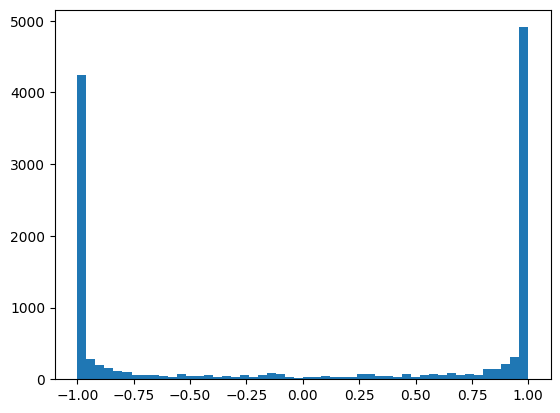

In [24]:
# quite extreme numbers
plt.hist(h2.view(-1).tolist(), 50)

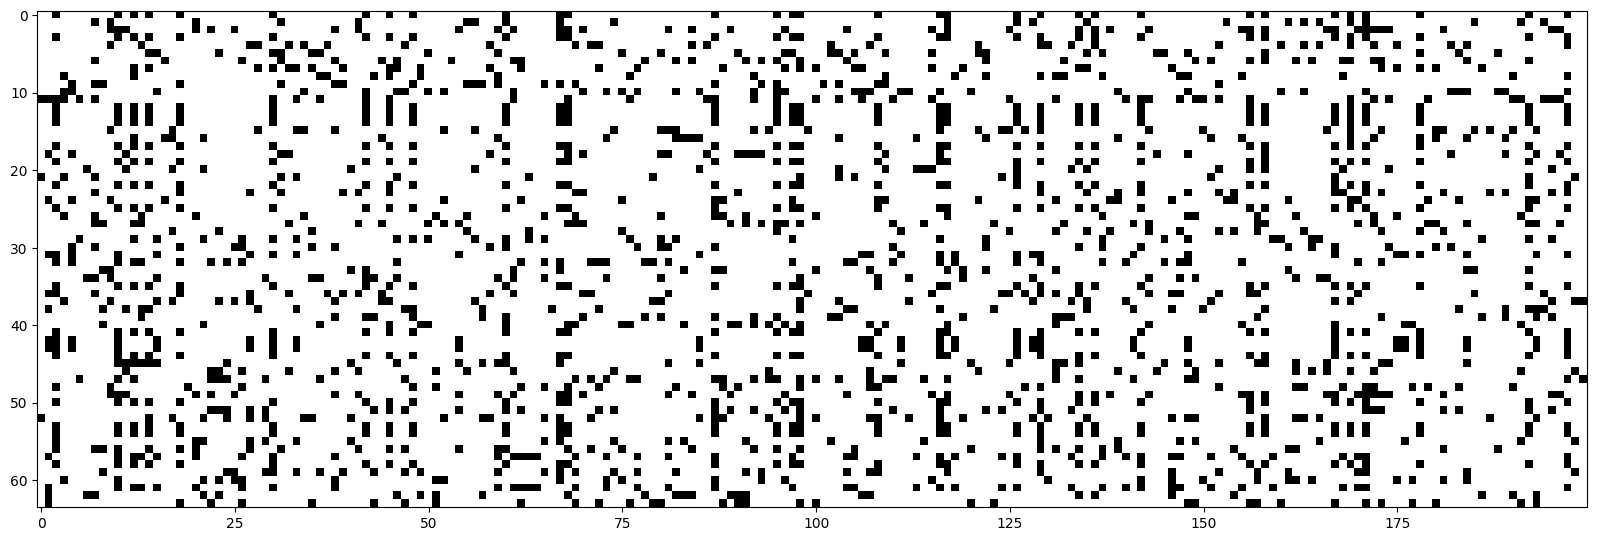

In [30]:
# too many saturated neurons
plt.figure(figsize=(20, 10))
plt.imshow(h1.abs() > 0.99, cmap="gray", interpolation="nearest")

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 1.100e+01, 1.000e+01,
        2.200e+01, 3.000e+01, 3.400e+01, 5.400e+01, 1.290e+02, 1.600e+02,
        1.660e+02, 2.490e+02, 3.890e+02, 4.800e+02, 5.410e+02, 6.990e+02,
        6.520e+02, 8.290e+02, 8.530e+02, 1.033e+03, 9.520e+02, 8.500e+02,
        8.220e+02, 7.990e+02, 6.830e+02, 5.840e+02, 4.250e+02, 3.700e+02,
        3.590e+02, 1.940e+02, 1.680e+02, 7.600e+01, 6.400e+01, 2.900e+01,
        1.900e+01, 1.600e+01, 2.100e+01, 7.000e+00, 4.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([-27.27158928, -26.28618866, -25.30078804, -24.31538742,
        -23.3299868 , -22.34458618, -21.35918556, -20.37378494,
        -19.38838432, -18.4029837 , -17.41758308, -16.43218246,
        -15.44678185, -14.46138123, -13.47598061, -12.49057999,
        -11.50517937, -10.51977875,  -9.53437813,  -8.54897751,
         -7.56357689,  -6.57817627,  -5.59277565,  -4.60

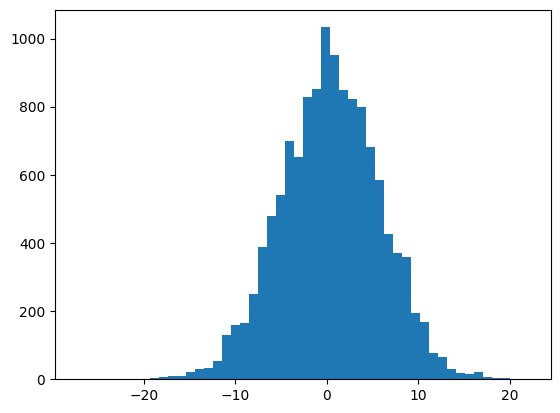

In [25]:
plt.hist(h1.view(-1).tolist(), 50)

In [74]:
# now the loss is smaller and reasonable. Avoid us to spend time on "easy" training
with torch.no_grad():
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g)
    w1 = (
        torch.randn((X.shape[1] * C.shape[1], 200), generator=g)
        * (5 / 3)
        / (X.shape[1] * C.shape[1] ** 0.5)
    )
    b1 = torch.randn(200, generator=g) * 0.01
    w2 = torch.randn((200, 27), generator=g) * 0.01  # produce smaller loss
    b2 = torch.randn(27, generator=g) * 0
    parameters = [C, w1, b1, w2, b2]

    ix = torch.randint(0, x_train.shape[0], (64,))
    embedding = C[x_train[ix]]
    h1 = embedding.view(-1, x_train.shape[1] * C.shape[1]) @ w1 + b1
    h2 = torch.tanh(h1)
    logits = h2 @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

# quite extreme numbers
print(loss)
print(torch.std(logits, dim=1, keepdim=True)[:3])
print(logits[0])

tensor(3.3003)
tensor([[0.0626],
        [0.0655],
        [0.0669]])
tensor([ 0.0644, -0.0513,  0.0031,  0.0633, -0.0932, -0.1393, -0.0718,  0.0365,
         0.0212, -0.0620, -0.0644,  0.1151, -0.0387, -0.1209,  0.0074,  0.0207,
        -0.0554,  0.0535,  0.0304, -0.0972, -0.0463,  0.0538, -0.0462, -0.0434,
        -0.0360, -0.0233, -0.0574])


(array([240., 284., 292., 288., 293., 277., 278., 314., 233., 256., 243.,
        250., 225., 211., 243., 207., 229., 221., 225., 231., 213., 199.,
        204., 241., 213., 224., 217., 243., 230., 200., 235., 248., 216.,
        237., 239., 250., 238., 233., 279., 227., 291., 259., 295., 329.,
        267., 311., 355., 362., 381., 324.]),
 array([-9.97893035e-01, -9.57951460e-01, -9.18009884e-01, -8.78068309e-01,
        -8.38126733e-01, -7.98185158e-01, -7.58243582e-01, -7.18302007e-01,
        -6.78360431e-01, -6.38418856e-01, -5.98477280e-01, -5.58535705e-01,
        -5.18594129e-01, -4.78652554e-01, -4.38710978e-01, -3.98769403e-01,
        -3.58827827e-01, -3.18886251e-01, -2.78944676e-01, -2.39003100e-01,
        -1.99061525e-01, -1.59119949e-01, -1.19178374e-01, -7.92367983e-02,
        -3.92952228e-02,  6.46352768e-04,  4.05879283e-02,  8.05295038e-02,
         1.20471079e-01,  1.60412655e-01,  2.00354230e-01,  2.40295806e-01,
         2.80237381e-01,  3.20178957e-01,  3.60120

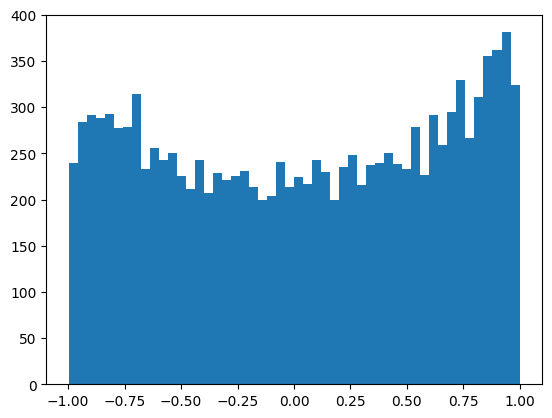

In [75]:
# quite extreme numbers
plt.hist(h2.view(-1).tolist(), 50)

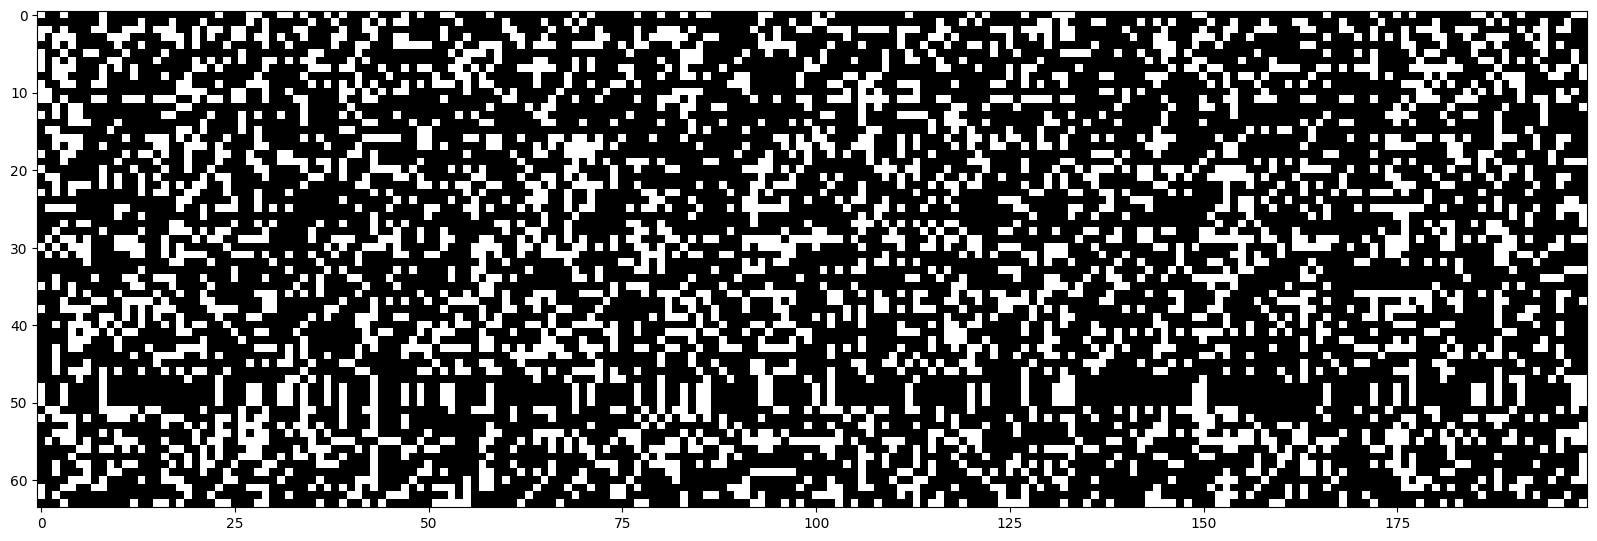

In [76]:
# too many saturated neurons
plt.figure(figsize=(20, 10))
plt.imshow(h1.abs() > 0.99, cmap="gray", interpolation="nearest")

tensor(0.0281) tensor(0.9951)
tensor(0.0024) tensor(0.9866)


(array([3.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 5.0000e+00,
        1.5000e+01, 2.4000e+01, 4.3000e+01, 6.9000e+01, 9.6000e+01,
        1.7000e+02, 2.5000e+02, 4.1600e+02, 6.9100e+02, 1.0710e+03,
        1.6630e+03, 2.6410e+03, 3.7520e+03, 5.2680e+03, 7.5240e+03,
        1.0024e+04, 1.2884e+04, 1.5761e+04, 1.8080e+04, 1.8853e+04,
        1.9131e+04, 1.8214e+04, 1.5725e+04, 1.3018e+04, 1.0230e+04,
        7.7440e+03, 5.5120e+03, 3.8130e+03, 2.5540e+03, 1.7470e+03,
        1.1080e+03, 7.5100e+02, 4.3700e+02, 2.7600e+02, 1.5700e+02,
        1.0600e+02, 7.6000e+01, 4.4000e+01, 2.7000e+01, 1.7000e+01,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-5.58598518e+00, -5.36274811e+00, -5.13951103e+00, -4.91627396e+00,
        -4.69303688e+00, -4.46979980e+00, -4.24656273e+00, -4.02332565e+00,
        -3.80008858e+00, -3.57685150e+00, -3.35361443e+00, -3.13037735e+00,
        -2.90714027e+00, -2.68390320e+00, -2.46066612e+00, -2.23742905e+00,
        -2.014

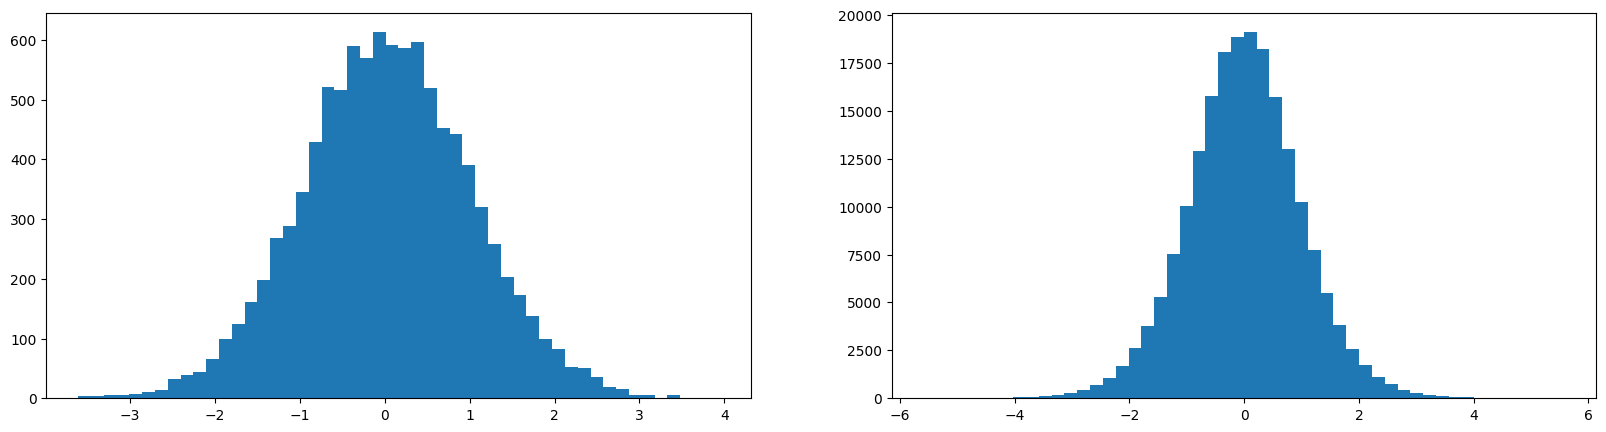

In [70]:
# see why is this happening use two guassian examples
# In order to compensate the saturated neurons caused by different activation function, we introduce a "gain"
# called kaiming gain, torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
x_tmp = torch.randn(1000, 10)
w_tmp = torch.randn(10, 200) / 10 ** 0.5  # fan_in ** 0.5
y_tmp = x_tmp @ w_tmp
print(x_tmp.mean(), x_tmp.std())
print(y_tmp.mean(), y_tmp.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x_tmp.view(-1).tolist(), 50)
plt.subplot(122)
plt.hist(y_tmp.view(-1).tolist(), 50)

**1.5 batch-norm**

In [80]:
# now the gain for compensation or the scale are not as important, still needed but more resilient to errors
n_embed = 8
n_hidden = 256
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
w1 = torch.randn((X.shape[1] * C.shape[1], n_hidden), generator=g) # * (5 / 3)/ (X.shape[1] * C.shape[1] ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, 27), generator=g) * 0.01  # produce smaller loss
b2 = torch.randn(27, generator=g) * 0

gamma = torch.ones((1, n_hidden))
beta = torch.zeros((1, n_hidden))
b_mean = torch.zeros((1, n_hidden))
b_std = torch.ones((1, n_hidden))

parameters = [C, w1, b1, w2, b2, gamma, beta]

In [82]:
loss_train, steps = [], []

def train(mini_batch: int = 32, momentum: float = 0.001, eps: float = 10**-5):

    for p in parameters:
        p.requires_grad = True

    for i in range(200000):
        ix = torch.randint(0, x_train.shape[0], (mini_batch,))
        embedding = C[x_train[ix]]
        # linear layer
        h1 = embedding.view(-1, x_train.shape[1] * C.shape[1]) @ w1 + b1  # see the special init doesn't matter too much anymore
        # batch norm layer
        h1_b_mean = h1.mean(0, keepdim=True)
        h1_b_std = h1.std(0, keepdim=True)
        h1 = gamma * (h1 - h1_b_mean) / h1_b_std + beta
        # batch norm layer for inference or evuation since the above are calculate on a small batch and can't represent all data
        with torch.no_grad():
            b_mean = (1 - momentum) * h1_b_mean + eps
            b_std = (1 - momentum) * h1_b_std + eps
        # non-linear (activation function)
        h2 = torch.tanh(h1)
        logits = h2 @ w2 + b2
        loss = F.cross_entropy(logits, y_train[ix])

        for p in parameters:
            p.grad = None

        loss.backward()

        lr = 0.1 if i < 10000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        loss_train.append(loss.log10().item())
        steps.append(i)

        if i % 10000 == 0:
            print(f"train loss: {loss}")
        
        # break

    print(f"train loss: {loss}")
    return loss_train, steps, b_mean, b_std


loss_train, steps, b_mean, b_std = train(mini_batch=64)

train loss: 3.262701988220215
train loss: 2.222844123840332
train loss: 2.2950010299682617
train loss: 2.3929073810577393
train loss: 2.2103021144866943
train loss: 2.375375270843506
train loss: 2.2831106185913086
train loss: 2.0732412338256836
train loss: 2.2914774417877197
train loss: 2.2225289344787598
train loss: 2.173797607421875
train loss: 1.9146443605422974
train loss: 2.1311862468719482
train loss: 2.0978763103485107
train loss: 2.0414247512817383
train loss: 2.1040403842926025
train loss: 2.1783063411712646
train loss: 1.9210104942321777
train loss: 2.0443854331970215
train loss: 2.222458839416504
train loss: 2.0729546546936035


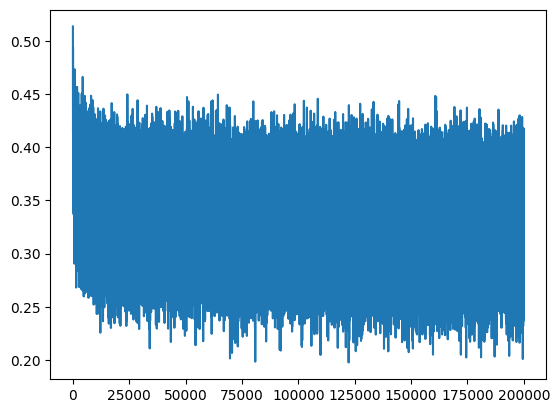

In [84]:
plt.plot(steps, loss_train)

## 2. Is there a better diagnositcs? Does batch-norm solve all the problem? See part 4